# Implementation of Multivariate Regression & K-Fold Cross Validation

### Needed Libraries

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

After importing the necessary libraries, we will load the dataset and determine the test size and also the number of k-folds. 

In [137]:
CARS_FILE = 'cars.csv'
TEST_SIZE = 0.2
K_FOLD = 5

In [138]:
cars_df = pd.read_csv(CARS_FILE)
k = K_FOLD

## Correlation Matrix

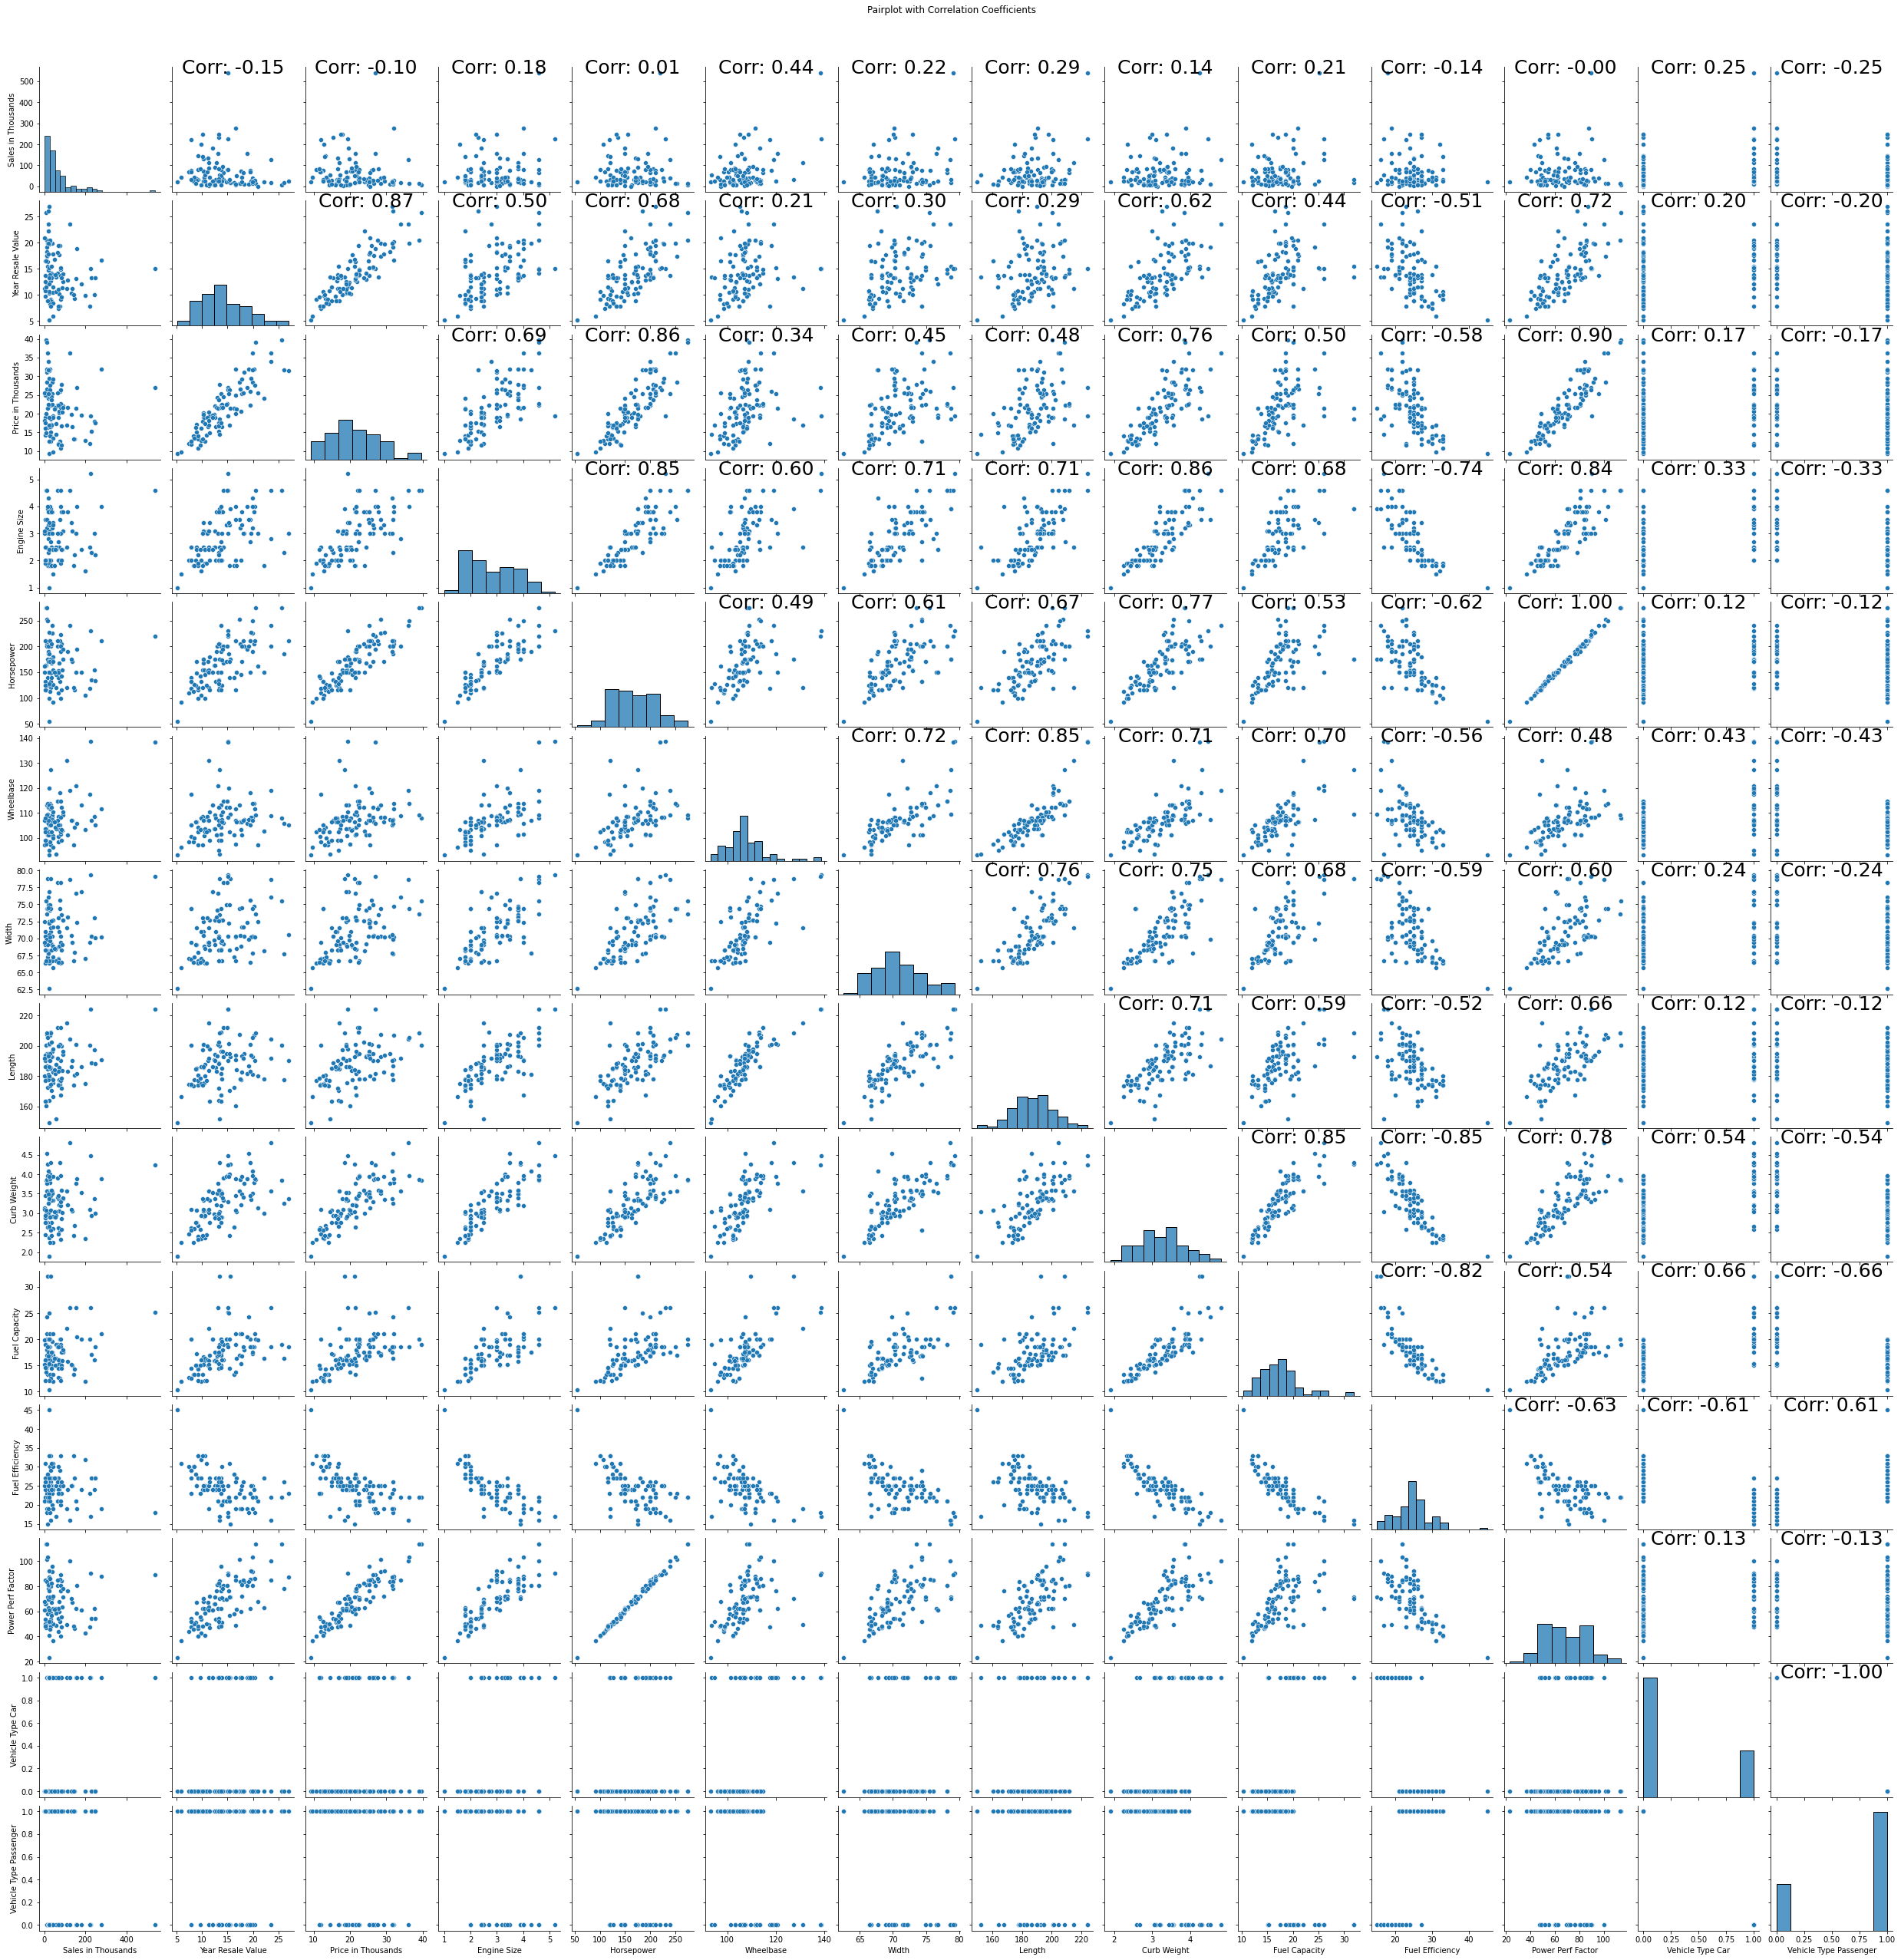

In [139]:
def scatter_plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    g = sns.pairplot(cars_df)

    for i, j in zip(*plt.np.tril_indices_from(g.axes, -1)):
        g.axes[j, i].annotate("Corr: {:.2f}".format(correlation_matrix.iloc[j, i]), 
                            (0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=25)

    plt.suptitle('Pairplot with Correlation Coefficients', y=1.02)
    plt.show()

scatter_plot_correlation_matrix(cars_df)

We can see from the above correlation matrix that many features are highly correlated with `Price in Thousands` including `HorsePower` with a correlation of 0.86, `Power Per Factor` with a correlation of 0.90, and `Curb Weight` with a correlation of 0.76.  
Also `Horsepower` and `Power Per Factor` are highly correlated with a correlation of 1.00 which is not surprising since `Power Per Factor` is calculated using `Horsepower`. Also`Curb Weight` has a correlation of 0.77 with `Horsepower` which is also not surprising since heavier cars tend to have more powerful engines.

## Multivariate Regression Implementation By Scratch

We normalize the data in order to make the range of values of each feature from 0 to 1. This is important because the features are on different scales and this can lead to a poor performance of the model.

In [140]:
def normalize_features(X):
    return (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

In `prepare_data()` function we drop the columns that are not needed for the regression model and normalize the data.

In [141]:
def prepare_data(df, target_column1, target_column2, dropped_cols=[]):
    dropped_cols.append(target_column2)
    dropped_cols.append(target_column2)
    X = df.drop(columns=dropped_cols, axis=1)
    y1, y2 = df[target_column1], df[target_column2]
    X = normalize_features(X)
    return X, y1, y2

The `MultivariateRegression()` class has the following methods:
- `fit()` method which trains the model using `gradient_descent()` method.
- `gradient_descent()` method which calculates the gradient descent. We calculate `dw` and `db` and update the weights and bias accordingly.
- `predict()` method which predicts the output using the weights and bias.
- `plot_learning_curve()` method which plots the learning curve of the model using the training and validation errors. The `cost()` method calculates the cost of the model using the mean squared error formula.  
The `learning_rate` and `num_of_iterations` are set to 0.01 and 1000 respectively.  
This regression model can have multiple target columns.

In [142]:
class MultivariateRegression:
    def __init__(self, df, learning_rate=0.01, num_iterations=1000):
        self.df = df
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.m, self.n = self.X_train.shape
        self.num_targets = self.y_train.shape[1]
        self.weights = np.zeros((self.n, self.num_targets))
        self.bias = np.zeros(self.num_targets)
        self.costs = []

        for i in range(self.num_iterations):
            self.gradient_descent()

        return self

    def gradient_descent(self):
        y_pred = self.predict(self.X_train)
        dw = -(2 / self.m) * np.dot(self.X_train.T, (self.y_train - y_pred))
        db = (-2 / self.m) * np.sum(self.y_train - y_pred, axis=0)

        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db
        self.costs.append(self.cost(y_pred, self.y_train))

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def cost(self, y_pred, y):
        return np.mean((y_pred - y) ** 2)

    def plot_learning_curve(self):
        targes_columns = ['Price in Thousands', 'Horsepower']
        plt.plot(range(self.num_iterations), self.costs)
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title('Learning Curve for ' + ', '.join(targes_columns))  # Use column names for multiple targets
        plt.show()



The `plot_actual_vs_predicted()` function plots the scatter plot of the actual vs predicted values of the model

In [143]:

def plot_actual_vs_predicted(y_true1, y_pred1, y_true2, y_pred2, column_names):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].scatter(y_true1, y_pred1)
    axes[0].plot(y_true1, y_true1, color='red', linestyle='-')
    axes[0].set_xlabel('Actual')
    axes[0].set_ylabel('Predicted')
    axes[0].set_title('Actual vs Predicted for ' + column_names[0])

    axes[1].scatter(y_true2, y_pred2)
    axes[1].plot(y_true2, y_true2, color='red', linestyle='-')
    axes[1].set_xlabel('Actual')
    axes[1].set_ylabel('Predicted')
    axes[1].set_title('Actual vs Predicted for ' + column_names[1])

    plt.tight_layout()    
    plt.show()

The `run_regression()` creates the regression model using the `MultivariateRegression()` class and plots the learning curve and the actual vs predicted values.

In [144]:
def run_regression(df, target_column1, target_column2, dropped_features=[]):
    X, y1, y2 = prepare_data(df, target_column1, target_column2, dropped_features)
    X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state=42)
    regression = MultivariateRegression(df)
    regression.fit(X_train, np.column_stack((y1_train, y2_train)))
    y1_pred, y2_pred = regression.predict(X_test).T
    plot_actual_vs_predicted(y1_test, y1_pred, y2_test, y2_pred, [target_column1, target_column2])
    return regression

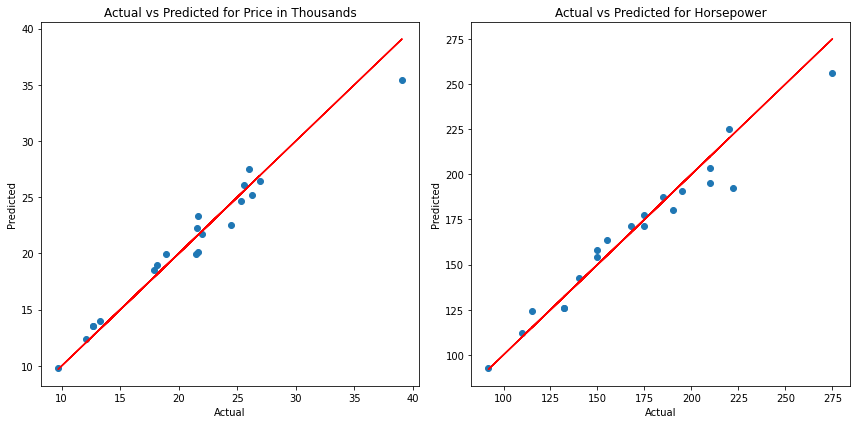

In [145]:
regressor = run_regression(cars_df, 'Price in Thousands', 'Horsepower')

As we can see from the scatter plot of the actual vs predicted values, the model is able to predict the values of `Price in Thousands` and `Horsepower` quite well as the dots are near the line of best fit.

### Plotting the Accuracy of the Model

The `plot_accuracy_statistics()` function is used for plotting accuracy metrics for regression which are `Mean Absolute Error`, `Mean Squared Error`, `root mean square error`, `R2 score`, and `Adjusted R2 score` that got familiar with in the previous assignment.

In [146]:
def plot_accuracy_statistics(accuracy_target1, accuracy_target2, x_label, k, doesUseKFold=False):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    colors = ['blue', 'green', 'red', 'purple']
    labels = ['RMSE', 'MAE', 'R2', 'Adjusted R2']
    rmses = [acc['RMSE'] for acc in accuracy_target1]
    mses1 = [acc['MSE'] for acc in accuracy_target1]
    maes = [acc['MAE'] for acc in accuracy_target1]
    r2s = [acc['R2_score'] for acc in accuracy_target1]
    adjusted_r2s = [acc['Adjusted_R2_score'] for acc in accuracy_target1]
    
    for metric, color, label in zip([rmses, maes, r2s, adjusted_r2s], colors, labels):
        axes[0].plot(range(1, len(metric) + 1), metric, color=color, label=label)
    axes[0].set_xlabel(x_label)
    if doesUseKFold:
        axes[0].set_xticks(range(1, k + 1))
    axes[0].set_ylabel('Accuracy')
    title1 = 'Accuracy Statistics for ' + accuracy_target1[0]['target'] + " across different " + x_label + "s"
    axes[0].set_title(title1)
    axes[0].legend()

    rmses = [acc['RMSE'] for acc in accuracy_target2]
    mses2 = [acc['MSE'] for acc in accuracy_target2]
    maes = [acc['MAE'] for acc in accuracy_target2]
    r2s = [acc['R2_score'] for acc in accuracy_target2]
    adjusted_r2s = [acc['Adjusted_R2_score'] for acc in accuracy_target2]
    
    
    for metric, color, label in zip([rmses, maes, r2s, adjusted_r2s], colors, labels):
        axes[1].plot(range(1, len(metric) + 1), metric, color=color, label=label)
    axes[1].set_xlabel(x_label)
    if doesUseKFold:
        axes[1].set_xticks(range(1, k + 1))
    axes[1].set_ylabel('Accuracy')
    title2 = 'Accuracy Statistics for ' + accuracy_target2[0]['target'] + " across different " + x_label + "s"
    axes[1].set_title(title2)
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    axes[0].plot(range(1, len(mses1) + 1), mses1, color='orange', label="MSE")
    if doesUseKFold:
        axes[0].set_xticks(range(1, k + 1))
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title(title1)
    axes[0].legend()
    
    axes[1].plot(range(1, len(mses2) + 1), mses2, color='orange', label="MSE")
    if doesUseKFold:
        axes[1].set_xticks(range(1, k + 1))
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title(title2)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

### Accuracy Across Different Random States

The `calc_accuracy()` function returns a dictionary consists of accuracy metrics.

In [147]:
def calc_accuracy(y_test, y_pred, target_column, X_test):
    r2 = r2_score(y_test, y_pred)
    accuracy = {
        'target': target_column,
        'MSE':  mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2_score': r2,
        'Adjusted_R2_score': 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - len(X_test.columns) - 1)
    }
    return accuracy

The `get_accuracy_across_random_states()` calculates the accuracy metrics for random states in (1, 50).

In [148]:
def get_statistics_across_random_states(df, target_column1, target_column2, num_states, dropped_features = []):
    accuracy_target1, accuracy_target2 = [], []
    for i in range(num_states):
        X, y1, y2 = prepare_data(df, target_column1, target_column2, dropped_features)
        X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state=i)
        regression = MultivariateRegression(df)
        regression.fit(X_train, np.column_stack((y1_train, y2_train)))
        y1_pred, y2_pred = regression.predict(X_test).T
        accuracy_target1.append(calc_accuracy(y1_test, y1_pred, target_column1, X_test))
        accuracy_target2.append(calc_accuracy(y2_test, y2_pred, target_column2, X_test))    
    return accuracy_target1, accuracy_target2

#### Accuracy Across Different Random States for `Price in Thousands` and `Horsepower`

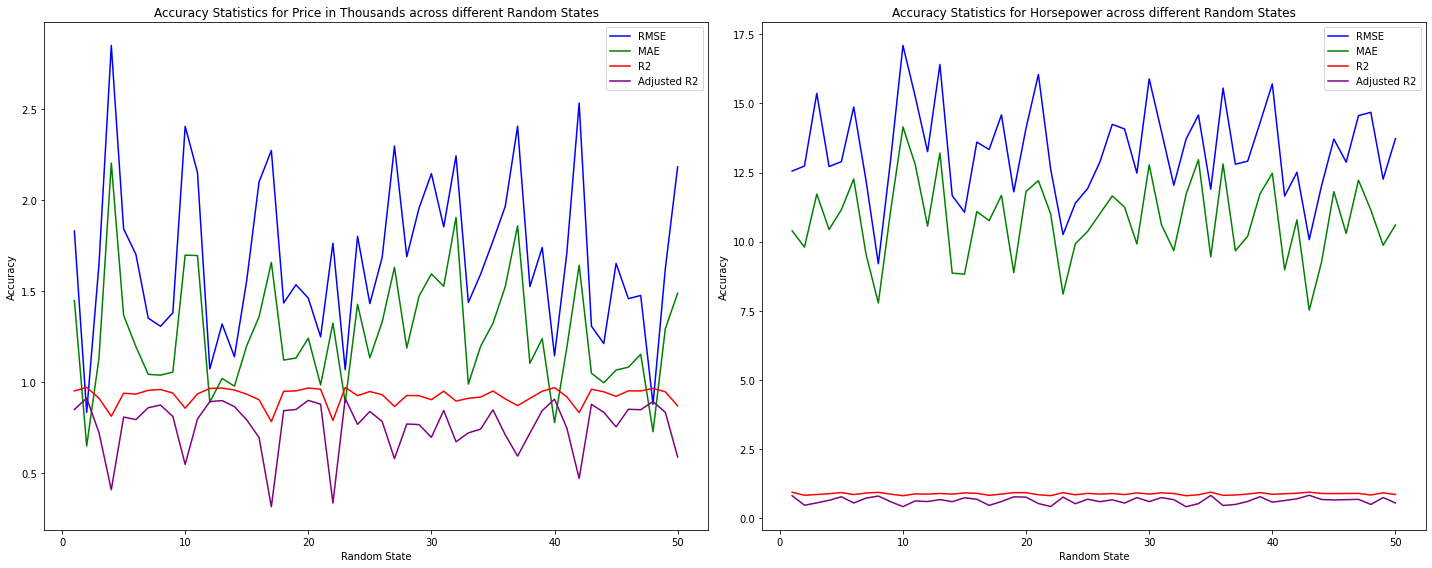

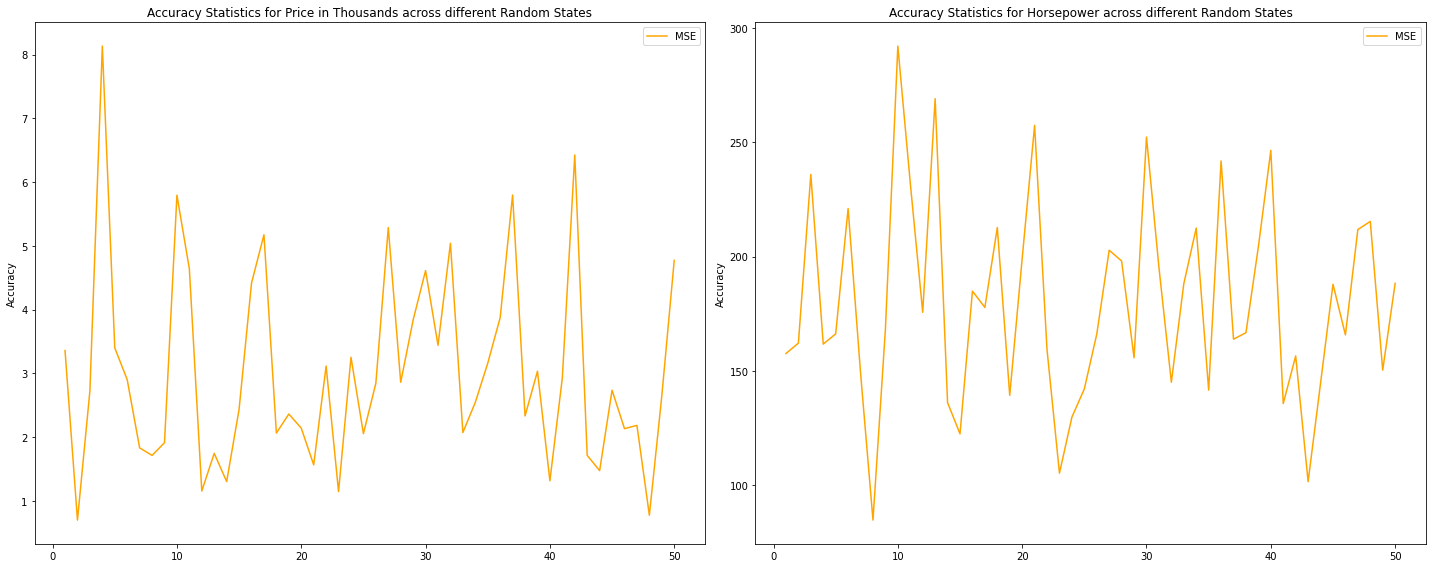

Minimum value for Price in Thousands:  9.235
Maximum value for Price in Thousands:  39.665

Minimum value for Horsepower:  55
Maximum value for Horsepower:  275


In [149]:
accuracy_target1, accuracy_target2 = get_statistics_across_random_states(cars_df, 'Price in Thousands', 'Horsepower', 50)
plot_accuracy_statistics(accuracy_target1, accuracy_target2,  'Random State', k, False)
print("Minimum value for Price in Thousands: ", cars_df['Price in Thousands'].min())
print("Maximum value for Price in Thousands: ", cars_df['Price in Thousands'].max())
print()
print("Minimum value for Horsepower: ", cars_df['Horsepower'].min())
print("Maximum value for Horsepower: ", cars_df['Horsepower'].max())

An R-squared (R2) score equal to 1 indicates that the model explains all of the variability of the response data around its mean. In other words, it perfectly predicts the target variable.  
An RMSE (Root Mean Squared Error) between 1 to 4 means that, on average, our model's predictions are off by approximately 1 to 4 units in the same scale as your target variable. As pur target variable does not represent a very precise measurement or a small scale, an RMSE between 1 to 4 might be considered acceptable. Aso MAE (Mean Absolute Error) is the average of the absolute values of the errors of the predictions. It gives us an idea of how wrong the predictions were which is similar to RMSE in our case. MSE is $RMSE^2$ so its range is wider than RMSE.  
The adjusted R-squared (R2) score, ranging from 0 to 1, measures the proportion of the variance in the dependent variable (in this case, car prices in thousands of dollars) that is explained by the independent variables in the model. Overall, a higher adjusted R2 score indicates a better fit of the model to the data and a greater ability to predict car prices accurately based on the included features.  
Also the accuracy metrics calculated for the `Horsepower` feature are quite well due to the range of horsepower values which are not very high. Also as we can see `MAE`, `MSE`, and `RMSE` are higher in `Horsepower` and that is because the higher range of values in this column.

### Plotting the Learning Curve

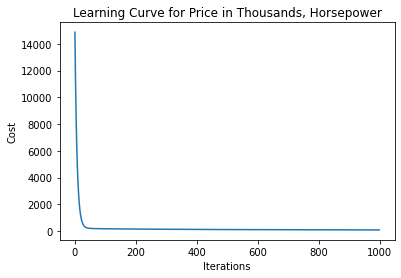

In [150]:
regressor.plot_learning_curve()

As we can see, the Learning Curve is plotted for the model using the `plot_learning_curve()` function. The curve is considered a good learning curve for regression model.

## Multivariate Regression Implementation using sklearn library

We use `LinearRegression()` from `sklearn.linear_model` to implement the multivariate regression model. We use the same dataset and the same features as we used in the previous implementation.

In [151]:
def run_sklearn_regression(df, target_column1, target_column2, dropped_feautures = []):
    X, y1, y2 = prepare_data(df, target_column1, target_column2, dropped_feautures)
    X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state=42)
    regression = LinearRegression()
    regression.fit(X_train, np.column_stack((y1_train, y2_train)))
    y1_pred, y2_pred = regression.predict(X_test).T
    plot_actual_vs_predicted(y1_test, y1_pred, y2_test, y2_pred, [target_column1, target_column2])
    accuracy_target1 = calc_accuracy(y1_test, y1_pred, target_column1, X_test)
    accuracy_target2 = calc_accuracy(y2_test, y2_pred, target_column2, X_test)
    
    return regression, accuracy_target1, accuracy_target2

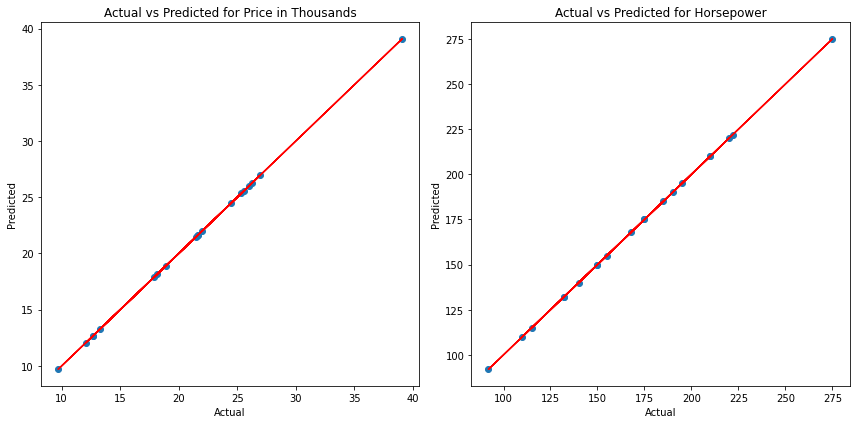

In [152]:
price_regressor_sklearn, accuracy_target1, accuracy_target2 = run_sklearn_regression(cars_df, 'Price in Thousands', 'Horsepower')

As we can see the `Price in Thousands` and `Horsepower` features are predicted quite well by the model as the dots are near the line of best fit which shows that they almost have linear relationship with other feautures. 

In [153]:
def print_statistics(accuracies):
    for accuracy in accuracies:
        print('Statistics for', accuracy['target'])
        print('MSE:', accuracy['MSE'])
        print('RMSE:', accuracy['RMSE'])
        print('MAE:', accuracy['MAE'])
        print('R2:', accuracy['R2_score'])
        print('Adjusted R2:', accuracy['Adjusted_R2_score'])
        print('--------------------------------------------------')

The `print_statistics()` function prints the accuracy metrics.

In [154]:
print_statistics([accuracy_target1, accuracy_target2])

Statistics for Price in Thousands
MSE: 2.1946110383248548e-28
RMSE: 1.481421964979882e-14
MAE: 1.127986593019159e-14
R2: 1.0
Adjusted R2: 1.0
--------------------------------------------------
Statistics for Horsepower
MSE: 2.0553691809905288e-16
RMSE: 1.4336558795577581e-08
MAE: 1.1566653057570874e-08
R2: 1.0
Adjusted R2: 1.0
--------------------------------------------------


As it is clear from the accuracy metrics, the model implemented with `sklearn library` is able to predict the values of `Price in Thousands` and `Horsepower` very well as the $R^2$ score and adjusted $R^2$ score are equal to 1 and `MSE`, `RMSE`, and `MAE` are near zero.

## Manual K-Fold Cross Validation Implementation

The `k_fold_cross_validation()` function implements the k-fold cross validation using the `MultivariantRegression()` class that we've implementes so far. in order to calculate the indices of test and train data, we firstly shuffle the data and then partition the data to `k` groups (k is equal to 5 in this case). Each time on of these k groups is the test data and the other groups are used for training. So we 

In [155]:
def k_fold_cross_validation(X, y1, y2, k, model, target_column1, target_column2):
    m, _ = X.shape
    indices = np.arange(m)
    np.random.shuffle(indices)
    fold_size = m // k
    accuracy_target1, accuracy_target2 = [], []
    for i in range(k):
        print("Fold ", i+1)
        fold_indices = indices[i * fold_size:(i + 1) * fold_size]
        X_train = X[np.logical_not(np.isin(np.arange(len(X)), fold_indices))]
        y1_train = y1[np.logical_not(np.isin(np.arange(len(y1)), fold_indices))]
        y2_train = y2[np.logical_not(np.isin(np.arange(len(y2)), fold_indices))]
        X_test = X[np.isin(np.arange(len(X)), fold_indices)]
        y1_test = y1[np.isin(np.arange(len(y1)), fold_indices)]
        y2_test = y2[np.isin(np.arange(len(y2)), fold_indices)]
        model.fit(X_train, np.column_stack((y1_train, y2_train)))
        y1_pred, y2_pred = model.predict(X_test).T
        accuracy_target1.append(calc_accuracy(y1_test, y1_pred, target_column1, X_test))
        accuracy_target2.append(calc_accuracy(y2_test, y2_pred, target_column2, X_test))  
        plot_actual_vs_predicted(y1_test, y1_pred, y2_test, y2_pred, [target_column1, target_column2])
        model.plot_learning_curve()
        print('-------------------------------------------------------')
    return accuracy_target1, accuracy_target2

In [156]:
def run_cross_validation(target_column1, target_column2, df, k = 5, dropped_features = []):
    X, y1, y2 = prepare_data(df, target_column1, target_column2, dropped_features)
    model = MultivariateRegression(df)
    accuracy_target1, accuracy_target2 = k_fold_cross_validation(X, y1, y2, k, model, target_column1, target_column2)
    return accuracy_target1, accuracy_target2

### `Price in Thousands` Prediction

Fold  1


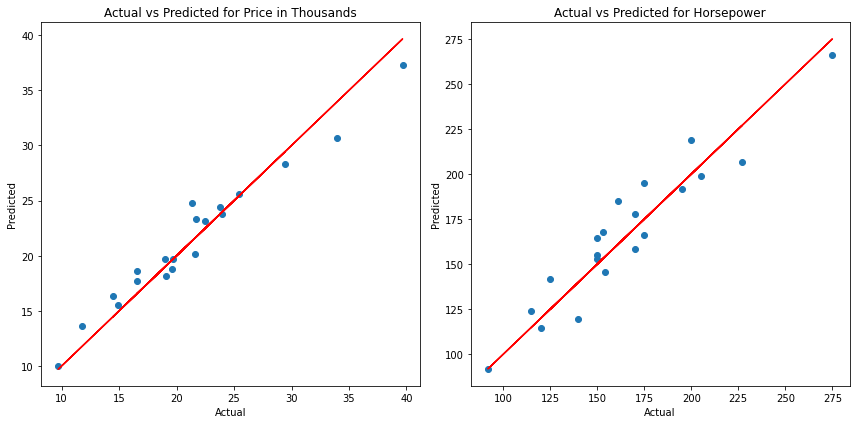

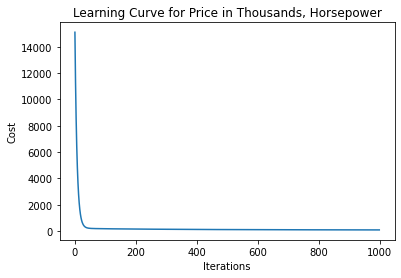

-------------------------------------------------------
Fold  2


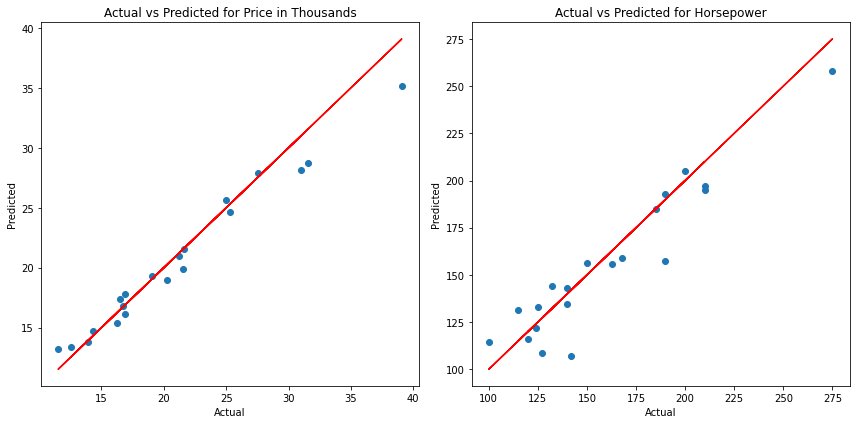

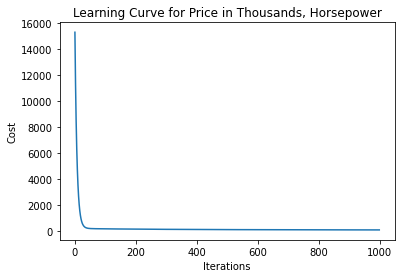

-------------------------------------------------------
Fold  3


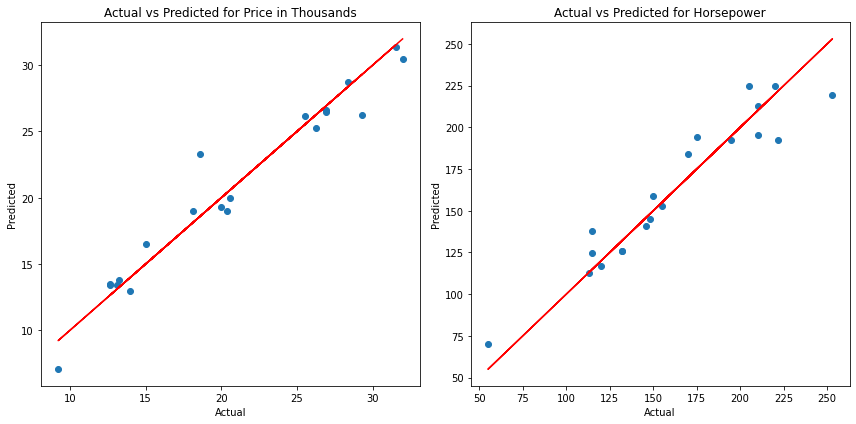

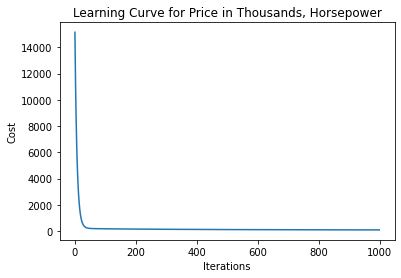

-------------------------------------------------------
Fold  4


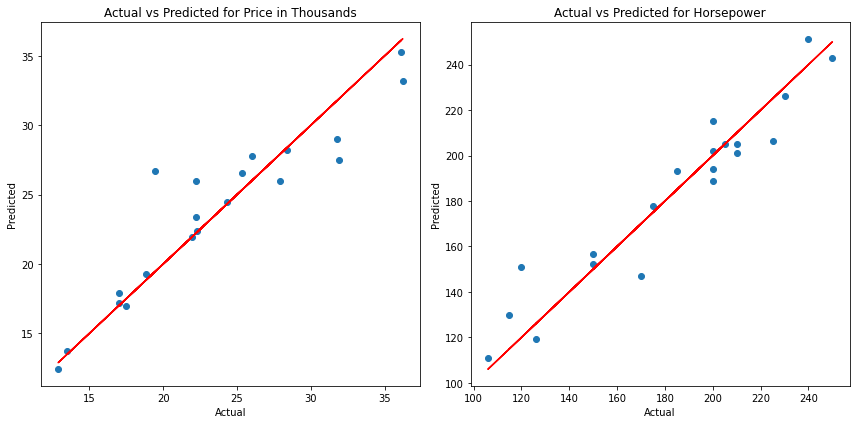

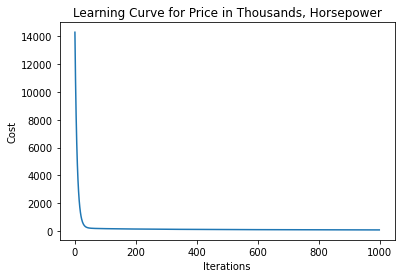

-------------------------------------------------------
Fold  5


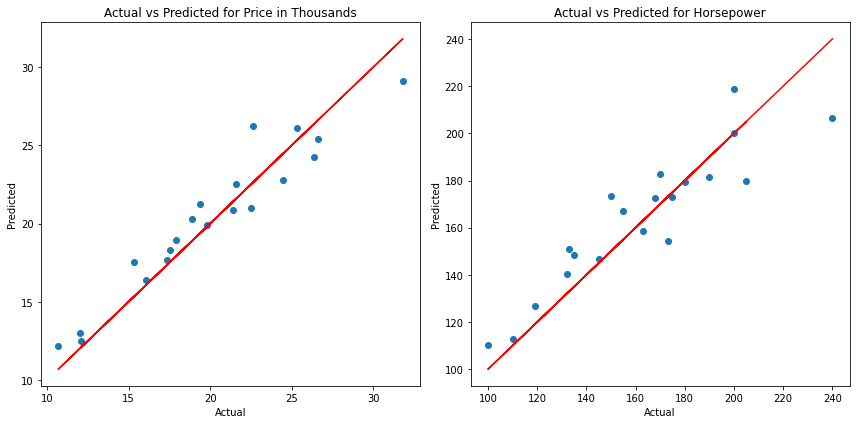

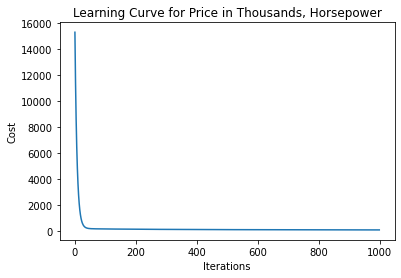

-------------------------------------------------------


In [157]:
accuracy_target1, accuracy_target2 = run_cross_validation('Price in Thousands', 'Horsepower', cars_df, k)

We can see the learning curve and also the scatter plot for each fold.

#### `Price in Thousands` and `Horsepower` Prediction Accuracy Measurement

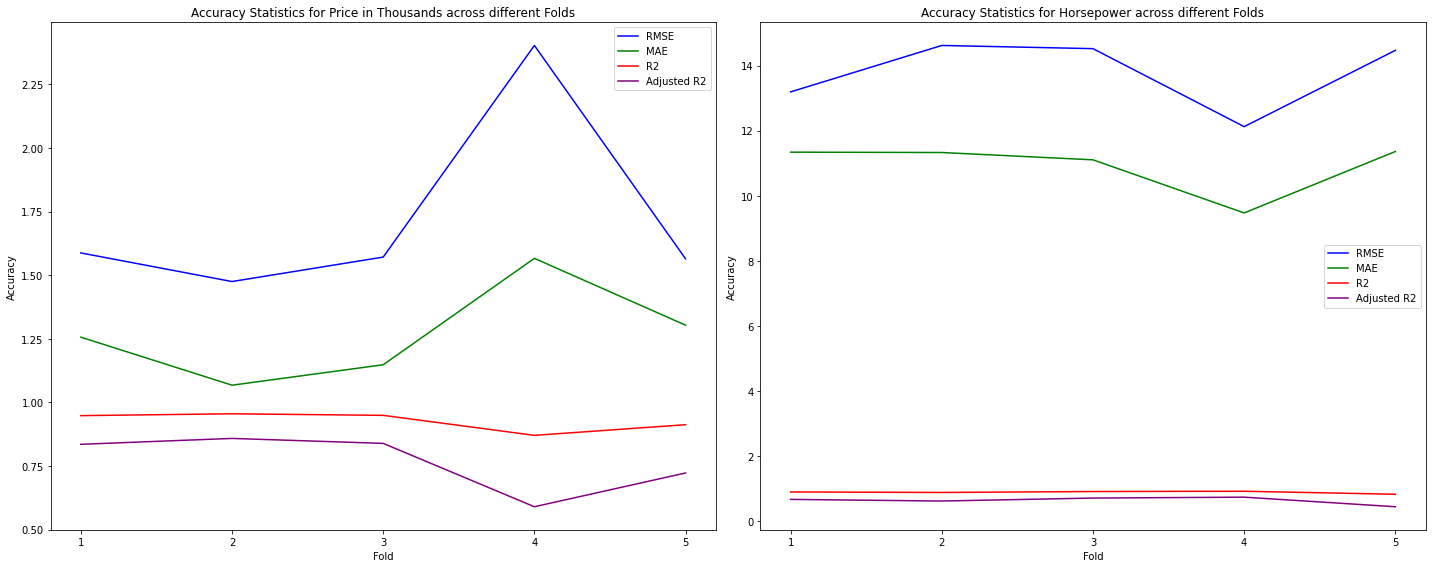

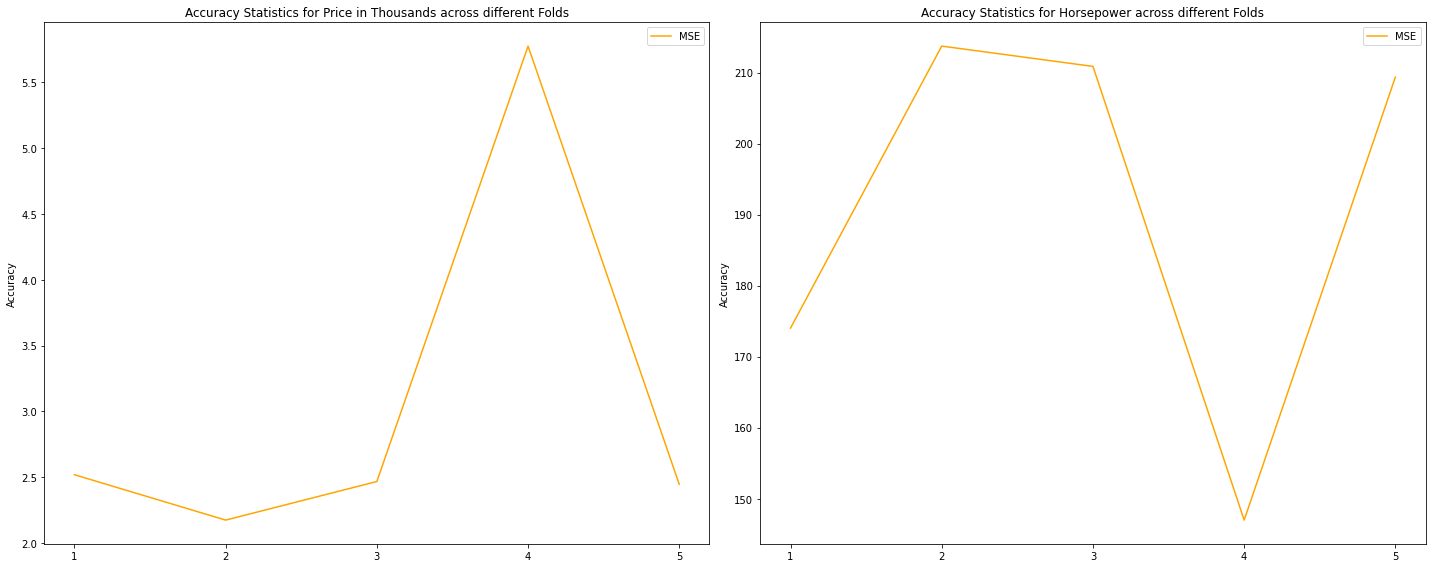

In [158]:
plot_accuracy_statistics(accuracy_target1, accuracy_target2, 'Fold', k, True)

We can see the changes of accuracy metrics in the above plots. Different metrics act differently in different folds for example accuracy metrics acts the best in fold 2 for `Price in Thousands` while the best result is in fold 4 for `Horsepower`.

## K-Fold Cross Validation Implementation using sklearn library

The `run_sklearn_cross_validation()` uses `KFold()` from `sklearn.model_selection` to implement the k-fold cross validation. The `cross_val_score()` method from `sklearn.model_selection` is used to calculate the accuracy metrics for each fold.

In [159]:
def run_sklearn_cross_validation(target_column1, target_column2, df, k = 5, dropped_features = []):
    kf = KFold(n_splits=k, shuffle=True)
    X, y1, y2 = prepare_data(df, target_column1, target_column2, dropped_features)
    i = 0
    accuracy_target1, accuracy_target2 = [], []
    model = LinearRegression()
    for train_index, test_index in kf.split(X):
        print("Fold ", i+1)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y1_train, y1_test = y1.iloc[train_index], y1.iloc[test_index]
        y2_train, y2_test = y2.iloc[train_index], y2.iloc[test_index]
        model.fit(X_train, np.column_stack((y1_train, y2_train)))
        y1_pred, y2_pred = model.predict(X_test).T
        i += 1
        plot_actual_vs_predicted(y1_test, y1_pred, y2_test, y2_pred, [target_column1, target_column2])
        accuracy_target1.append(calc_accuracy(y1_test, y1_pred, target_column1, X_test))
        accuracy_target2.append(calc_accuracy(y2_test, y2_pred, target_column2, X_test))
        print('-------------------------------------------------------------')
    return accuracy_target1, accuracy_target2

The `print_cross_validation_accuracy()` function is used to print the accuracy metrics for each fold.

In [160]:
def print_cross_validation_accuracy(accuracy_target1, accuracy_target2):
    for i in range(k):
        print_statistics([accuracy_target1[i], accuracy_target2[i]])
        print('======================================================================')
        

### `Price in Thousands` Prediction

Fold  1


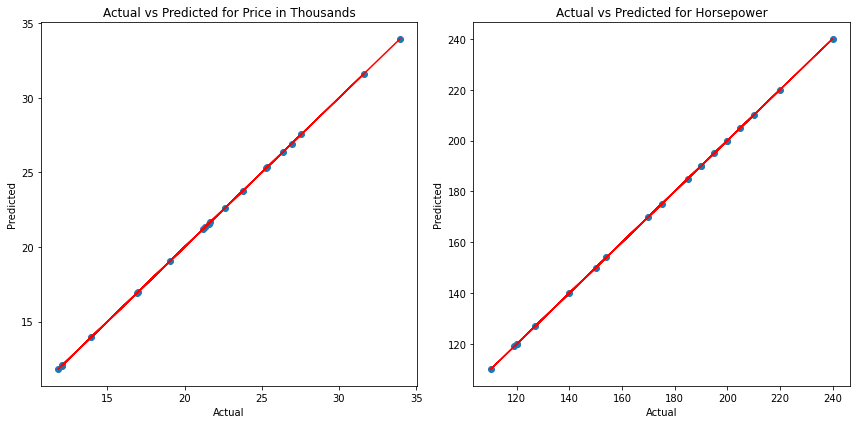

-------------------------------------------------------------
Fold  2


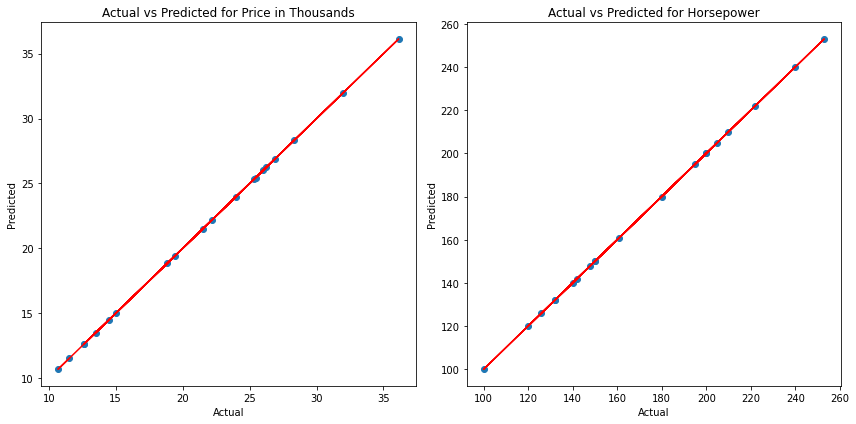

-------------------------------------------------------------
Fold  3


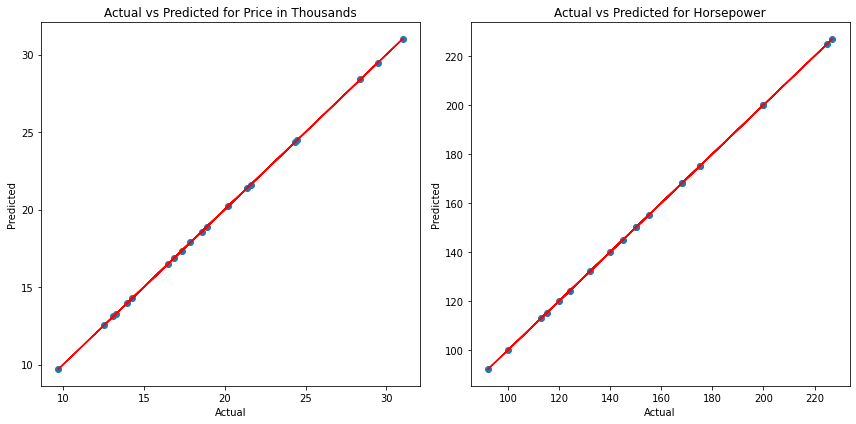

-------------------------------------------------------------
Fold  4


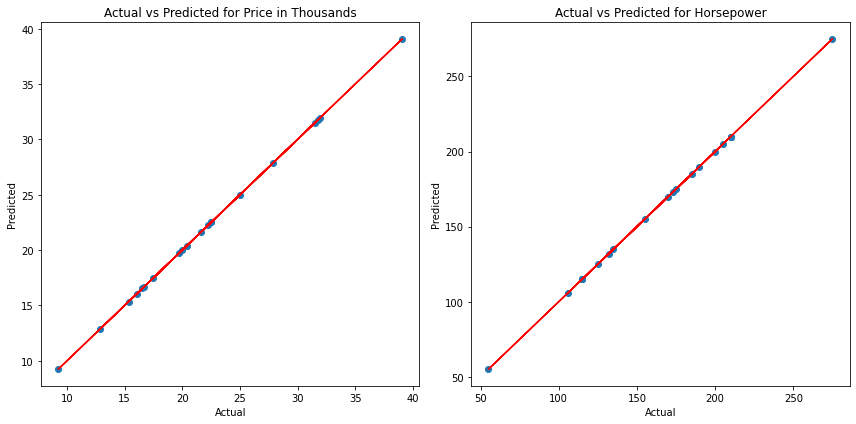

-------------------------------------------------------------
Fold  5


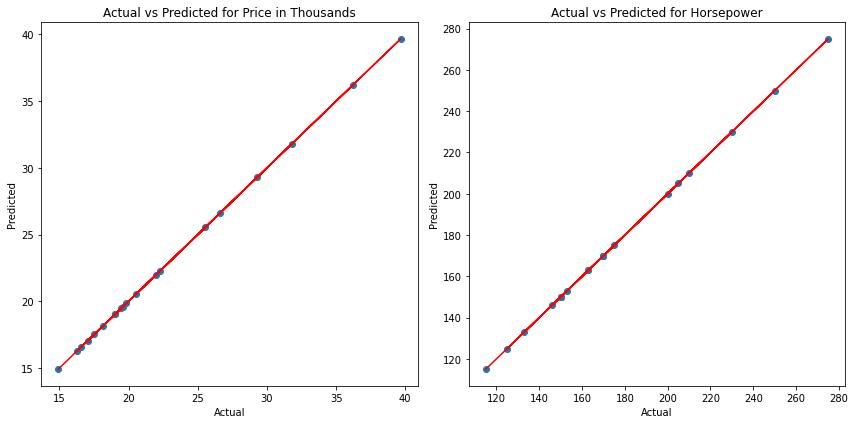

-------------------------------------------------------------


In [161]:
accuracy_target1, accuracy_target2 = run_sklearn_cross_validation('Price in Thousands', 'Horsepower', cars_df, k)


As we can see from the above scatter plots, the model is quite accurate in predicting the values of `Price in Thousands`and `Horsepower` in all folds.

#### Price in Thousands Prediction Accuracy Measurement Using Library

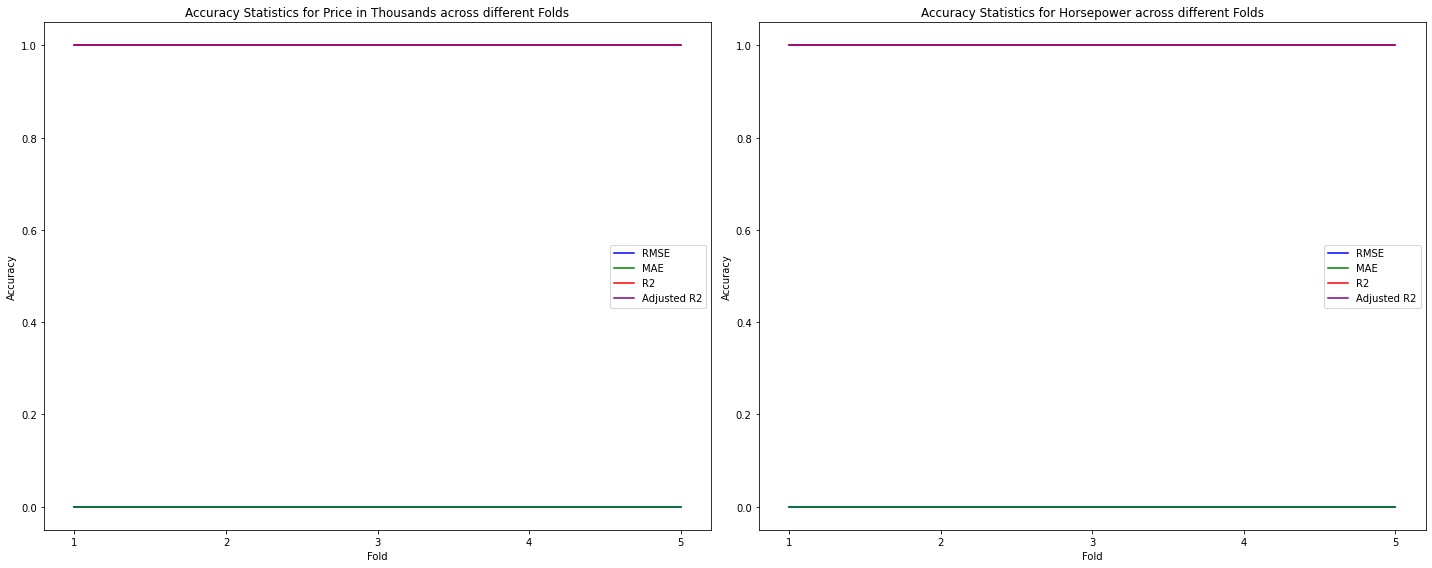

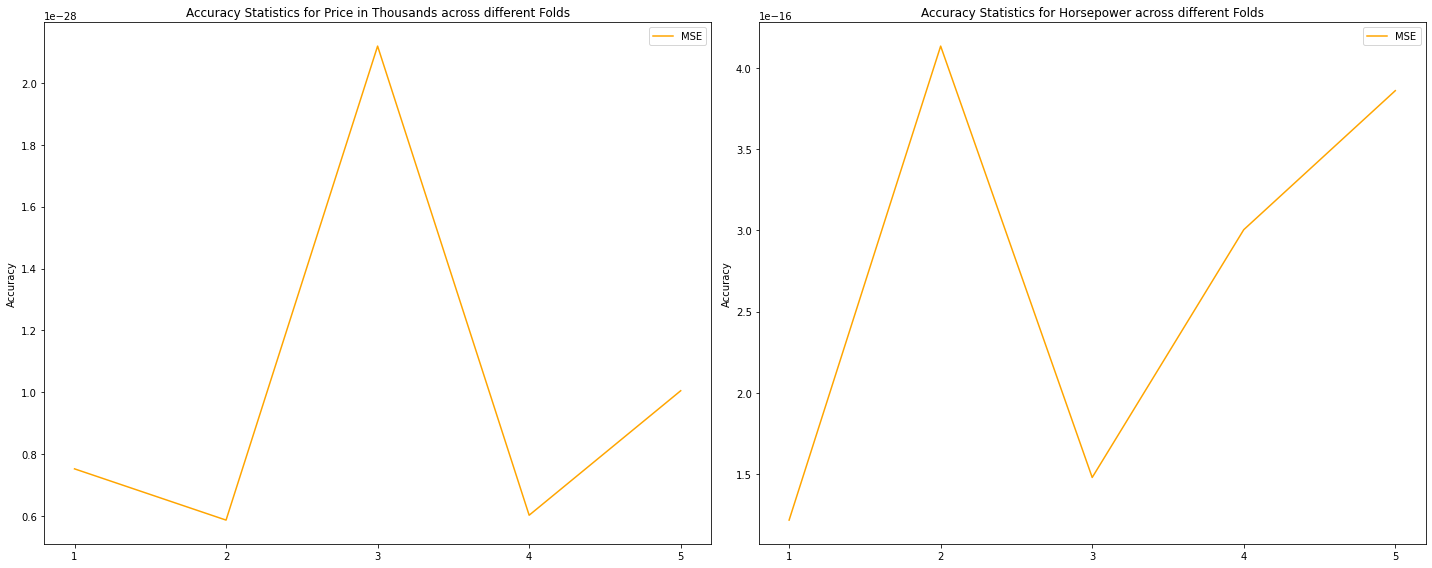

Statistics for Price in Thousands
MSE: 7.525733035808453e-29
RMSE: 8.675098290975414e-15
MAE: 6.483702463810914e-15
R2: 1.0
Adjusted R2: 1.0
--------------------------------------------------
Statistics for Horsepower
MSE: 1.2172257426827623e-16
RMSE: 1.1032795396828323e-08
MAE: 9.424838509630718e-09
R2: 1.0
Adjusted R2: 1.0
--------------------------------------------------
Statistics for Price in Thousands
MSE: 5.869125134844328e-29
RMSE: 7.661021560369302e-15
MAE: 6.217248937900877e-15
R2: 1.0
Adjusted R2: 1.0
--------------------------------------------------
Statistics for Horsepower
MSE: 4.133492414051007e-16
RMSE: 2.033099214020557e-08
MAE: 1.248927858910065e-08
R2: 1.0
Adjusted R2: 1.0
--------------------------------------------------
Statistics for Price in Thousands
MSE: 2.118880391423638e-28
RMSE: 1.455637451917076e-14
MAE: 1.2523315717771765e-14
R2: 1.0
Adjusted R2: 1.0
--------------------------------------------------
Statistics for Horsepower
MSE: 1.4794875803553829e-16

In [162]:
plot_accuracy_statistics(accuracy_target1, accuracy_target2, 'Fold', k, True)
print_cross_validation_accuracy(accuracy_target1, accuracy_target2)

We can see the accuracy metrics for each fold in the above cell. The $R^2$ score and adjusted $R^2$ score are both equal to 1 in all 5 folds. Other metrics also show that the model is quite accurate as they are really low and near zero.

**`Discuss the advantages and disadvantages of k-fold cross-validation. Can you also explain other types of cross-validation methods that could address the limitations and issues associated with k-fold cross-validation?`**  
K-Fold Cross Validation has several advantages including that it is a robust method for estimating the performance of a model on unseen data. It is also useful for small datasets as it allows for the training and testing of the model on different subsets of the data. k-fold cross-validation iteratively splits the data into k folds, ensuring that each data point is used for both training and validation. This leads to better utilization of available data for model evaluation. Also by averaging the evaluation metrics over k folds, k-fold cross-validation provides a more reliable estimate of model performance compared to a single train-test split. It helps in reducing the variance of the performance estimate.  
However, k-fold cross-validation has some limitations. It can be computationally expensive and time consuming, especially for large datasets or complex models. It can also be sensitive to the choice of k, which can affect the performance estimate. In addition, k-fold cross-validation may not be suitable for time-series data or when the data has a specific structure that needs to be preserved. Also it is sensitive to data distribution. The performance estimates obtained from k-fold cross-validation may vary depending on how the data is partitioned into folds. It could be sensitive to the distribution of data, especially if the data is imbalanced or has specific patterns.  
Other types of cross-validation methods that could address the limitations and issues associated with k-fold cross-validation include:
- Leave-One-Out Cross-Validation (LOOCV): In LOOCV, a single data point is used as the validation set, and the remaining data points are used for training. This process is repeated for each data point, resulting in k folds, where k is the number of data points. LOOCV is computationally expensive but provides a more accurate estimate of model performance, especially for small datasets.
- Stratified Cross-Validation: In stratified cross-validation, the data is partitioned into folds such that each fold contains an equal proportion of each class label. This helps to ensure that the model is evaluated on a representative sample of the data and can be useful for imbalanced datasets.
- Time-Series Cross-Validation: Time-series cross-validation is used for time-series data, where the order of data points is important. In time-series cross-validation, the data is split into training and validation sets based on time, with earlier data used for training and later data used for validation. This helps to evaluate the model's performance on unseen future data.
- Nested Cross-Validation: Nested cross-validation is used to tune hyperparameters and evaluate the model's performance. In nested cross-validation, an inner loop is used to tune hyperparameters using k-fold cross-validation, and an outer loop is used to evaluate the model's performance using another k-fold cross-validation. This helps to prevent overfitting and provides a more reliable estimate of model performance.
- Repeated Cross-Validation: Repeated cross-validation involves repeating the k-fold cross-validation process multiple times with different random splits of the data. This helps to reduce the variance of the performance estimate and provides a more robust evaluation of the model.

**`What metrics did you use to evaluate your manual implementations of multivariate regression and k-fold cross-validation, and why did you choose them?`**  
The metrics used to evaluate the manual implementations of multivariate regression and k-fold cross-validation include:
- Mean Absolute Error (MAE): MAE is the average of the absolute values of the errors of the predictions. It gives us an idea of how wrong the predictions were and is useful for understanding the magnitude of errors in the predictions.
- Mean Squared Error (MSE): MSE is the average of the squared errors of the predictions. It penalizes larger errors more than smaller errors and is useful for understanding the variance of errors in the predictions.
- Root Mean Squared Error (RMSE): RMSE is the square root of the average of the squared errors of the predictions. It is useful for understanding the magnitude of errors in the predictions in the same scale as the target variable.
- R-squared (R2) Score: R2 score measures the proportion of the variance in the dependent variable that is explained by the independent variables in the model. It ranges from 0 to 1, with 1 indicating a perfect fit of the model to the data.
- Adjusted R-squared (R2) Score: Adjusted R2 score is a modified version of the R2 score that adjusts for the number of independent variables in the model. It provides a more reliable estimate of model performance, especially for models with multiple independent variables.  
These metrics were chosen because they provide a comprehensive evaluation of the model's performance, including the magnitude of errors, the variance of errors, the proportion of variance explained by the model, and the reliability of the model's performance estimate. They help to assess the accuracy, precision, and generalization of the model to unseen data.